In [1]:
import pandas as pd

# Load annotated training data
annotated_df = pd.read_csv('training_data/train-classification_annotated.csv')
print(annotated_df.head())

          username          category
0    taskirancemal  Mom and Children
1    tam_kararinda              Food
2         spart4nn              Food
3  sosyalyiyiciler              Food
4  sonaydizdarahad  Mom and Children


In [2]:
import json

# Function to load JSONL data
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

training_data = load_jsonl('training_data/training-dataset-filtered-classification.jsonl')
print(len(training_data))

5415


In [3]:
# Create a dictionary for quick username lookup
username_to_profile = {}
for entry in training_data:
    username = entry['profile']['username']
    biography = entry['profile']['biography']
    posts = entry['posts']
    # Concatenate all post captions, converting None to an empty string
    captions = ' '.join([str(post.get('caption', '')) for post in posts if post.get('caption') is not None])
    username_to_profile[username] = {
        'biography': biography,
        'captions': captions
    }

In [4]:
# Add biography and captions to the annotated DataFrame
annotated_df['biography'] = annotated_df['username'].apply(lambda x: username_to_profile.get(x, {}).get('biography', ''))
annotated_df['captions'] = annotated_df['username'].apply(lambda x: username_to_profile.get(x, {}).get('captions', ''))

print(annotated_df.head())

          username          category  \
0    taskirancemal  Mom and Children   
1    tam_kararinda              Food   
2         spart4nn              Food   
3  sosyalyiyiciler              Food   
4  sonaydizdarahad  Mom and Children   

                                           biography  \
0                                     📍Antalya / Kaş   
1     Milliyet Pazar\nKalori Alacaksan Buna Değecek📚   
2  Küçük ev\nKamp ve doğa hayatı🏕\nMutfağımız doğ...   
3  Founder @bitte.izmir \nIZMIR yemek/seyahat foo...   
4  DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a.d.kids \n@dilanp...   

                                            captions  
0  Ah Merve ah.. #tineco #temizlik Çocukken baktı...  
1  Faydasız Deneyler Serisi’nde bu sefer blender’...  
2  Kütük ocağında et fajita...\n#nature#dinner#la...  
3  Keşif gibi keşifle geldim!cosi.gastro Çakallı ...  
4  Her şeye EYVALLAH 🤐 🤍 10.yıl ❤️ Şanlıurfa da E...  


In [5]:
# Load test usernames
with open('test_data/test-classification-round3.dat', 'r', encoding='utf-8') as f:
    test_usernames = [line.strip() for line in f.readlines()]

print(test_usernames)

['livapastanesi', 'barisgross', 'tusasshop', 'etolyadigital', 'tugrulonur', 'tulugozlu', 'gokidy', 'cengizgumus_official', 'krossbisiklet', 'haribochamallows', 'ozatashipyard', 'yenisafak', 'iamsiddeshjadhav', 'burcinterzioglu', 'steakhousegunaydin', 'baselifeclub', 'benismailyildirimm', 'imuneksfarma', 'dogakoyucatalca', 'sena.sener', 'kandilliborsarestaurant', 'selamiersoyy', 'deutz_fahr_turkey', 'cevaheer', 'tezatsanat', 'filtresizcom', 'palomamarina_suites', 'westchocolatemarina', 'sebnemcapa', 'rozetsepeti', 'ececesmioglu', 'ustapidecitr', 'gocaagonyali', 'maestro.sanat.kursu', 'oztayteksofficial', 'imtolstoyevski', 'turkervip', 'rustik.rus.restorani', 'guzellik_hemsiresi', 'mehmetcikvakfi', 'bruderturkiye', 'brandingturkiye', 'dogushyilmaz', 'crmbelediyesi', 'gcaturkiye', 'bskcemildeveci', 'lokmanhekimhastaneleri', 'trumpavm', 'resimlimagnet_com', 'ilaydaakdogan', 'karincaproduksiyon', 'ilkergodencemobilya', 'semihasahin', 'ogretmeninkaleminden_', 'narkoyjournal', 'kuzucu_mucevhe

In [6]:
from sklearn.preprocessing import LabelEncoder

# Define the categories
categories = [
    "Art",
    "Entertainment",
    "Fashion",
    "Food",
    "Gaming",
    "Health and Lifestyle",
    "Mom and Children",
    "Sports",
    "Tech",
    "Travel"
]

# Initialize Label Encoder
label_encoder = LabelEncoder()
label_encoder.fit(categories)

# Encode labels in the annotated DataFrame
annotated_df = annotated_df[annotated_df['category'].isin(categories)]  # Ensure only valid categories
annotated_df['label'] = label_encoder.transform(annotated_df['category'])

print(annotated_df['label'].head())

0    6
1    3
2    3
3    3
4    6
Name: label, dtype: int32


In [7]:
annotated_df['text'] = annotated_df.apply(
    lambda row: f"{row['username']} {row['biography']} {row['captions']}",
    axis=1
)

print(annotated_df['text'].head())

0    taskirancemal 📍Antalya / Kaş Ah Merve ah.. #ti...
1    tam_kararinda Milliyet Pazar\nKalori Alacaksan...
2    spart4nn Küçük ev\nKamp ve doğa hayatı🏕\nMutfa...
3    sosyalyiyiciler Founder @bitte.izmir \nIZMIR y...
4    sonaydizdarahad DİZDAR 🧿 Ahad 🧿 Dağhan \n@d.a....
Name: text, dtype: object


In [8]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    annotated_df['text'].tolist(),
    annotated_df['label'].tolist(),
    test_size=0.1,
    random_state=42,
    stratify=annotated_df['label']
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")

Training samples: 2467
Validation samples: 275


In [9]:
from transformers import BertTokenizer

# Load BERTurk tokenizer
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-cased')

# Tokenize the texts
max_length = 512  # BERT's maximum token length

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

In [10]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("GPU not available, using CPU")

class InstagramDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = InstagramDataset(train_encodings, train_labels)
val_dataset = InstagramDataset(val_encodings, val_labels)

Using GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [11]:
from transformers import BertForSequenceClassification

# Initialize the Model
model = BertForSequenceClassification.from_pretrained(
    'dbmdz/bert-base-turkish-cased',
    num_labels=len(categories),
    output_attentions=False,
    output_hidden_states=False
)

# Move model to the specified device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-turkish-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
from transformers import Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1': f1_score(p.label_ids, preds, average='weighted')
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    logging_strategy='steps',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    no_cuda=False,          # Ensure CUDA is enabled
    fp16=True,              # Enable mixed precision
    dataloader_num_workers=0,  # Set to 0 to avoid potential issues
    run_name="berturk-instagram-classifier"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

C:\Users\Deniz\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.064900,1.043354,0.665455,0.641693
2,0.974400,0.932591,0.709091,0.684254
3,0.480700,0.950267,0.720000,0.710119


TrainOutput(global_step=927, training_loss=1.1419178914869488, metrics={'train_runtime': 225.9005, 'train_samples_per_second': 32.762, 'train_steps_per_second': 4.104, 'total_flos': 1947424791803904.0, 'train_loss': 1.1419178914869488, 'epoch': 3.0})

In [14]:
trainer.evaluate()

{'eval_loss': 0.9502673149108887,
 'eval_accuracy': 0.72,
 'eval_f1': 0.7101191026643207,
 'eval_runtime': 1.8355,
 'eval_samples_per_second': 149.823,
 'eval_steps_per_second': 19.068,
 'epoch': 3.0}

In [15]:
# Identify usernames not in the annotated training set
annotated_usernames = set(annotated_df['username'])
test_usernames_set = set(test_usernames)
unknown_usernames = test_usernames_set - annotated_usernames

# print(f"Unknown usernames: {unknown_usernames}")

# Fetch profile data for unknown usernames
test_texts = []
for username in unknown_usernames:
    profile = username_to_profile.get(username, {})
    biography = profile.get('biography', '')
    captions = profile.get('captions', '')
    text = f"{username} {biography} {captions}"
    test_texts.append(text)

# Tokenize test texts
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length)


In [16]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])


test_dataset = TestDataset(test_encodings)

In [17]:
# Predict using the Trainer
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
pred_categories = label_encoder.inverse_transform(pred_labels)

# Map predictions back to usernames
unknown_usernames_list = list(unknown_usernames)
predicted_categories_dict = dict(zip(unknown_usernames_list, pred_categories))

print(predicted_categories_dict)

{'defneilgaz.com.tr': 'Entertainment', 'aquayasamofficial': 'Health and Lifestyle', 'dogushyilmaz': 'Tech', 'tekhnelogos': 'Tech', 'mesudiyelicom': 'Fashion', 'expertyol': 'Health and Lifestyle', 'ismailsenol': 'Sports', 'marka.333': 'Tech', 'byelergumus': 'Fashion', 'zamanebaba': 'Mom and Children', 'kulabelediyesi': 'Health and Lifestyle', 'normholding': 'Tech', 'supra_hubs': 'Tech', 'krossbisiklet': 'Sports', 'tulugozlu': 'Entertainment', 'olips_tr': 'Food', 'cebirecep': 'Health and Lifestyle', 'fixpacktr': 'Entertainment', 'flotalmirror': 'Fashion', 'batuconcept': 'Fashion', 'amazon.tr': 'Tech', 'gastrogezgin': 'Travel', 'tariszeytinyagi': 'Food', 'gulsjourney': 'Health and Lifestyle', 'celebizadeonline': 'Fashion', 'ondibilisim': 'Tech', 'yelkenrest': 'Food', 'vaziyetcomtr': 'Entertainment', 'tiesfed': 'Sports', 'piculetstore': 'Fashion', 'kosekahve': 'Food', 'wcollection': 'Fashion', 'antmarealacati': 'Travel', 'ciftelerbelediyesi': 'Health and Lifestyle', 'paragrafmedya': 'Tech'

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# =========================
# After Training is Complete
# =========================

# 1. Generate Predictions on the Validation Set
predictions = trainer.predict(val_dataset)

# 2. Extract Predicted Labels and True Labels
pred_logits = predictions.predictions
y_val_pred = np.argmax(pred_logits, axis=1)
y_val = predictions.label_ids

# 3. Compute Accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print("Accuracy:", accuracy)

# 4. Generate Classification Report
target_names = label_encoder.classes_  # Ensure this matches your label encoder
report = classification_report(y_val, y_val_pred, target_names=target_names, zero_division=0)
print("\nClassification Report:")
print(report)

Accuracy: 0.72

Classification Report:
                      precision    recall  f1-score   support

                 Art       0.70      0.37      0.48        19
       Entertainment       0.50      0.44      0.47        32
             Fashion       0.69      0.80      0.74        30
                Food       0.84      0.90      0.87        51
              Gaming       0.00      0.00      0.00         1
Health and Lifestyle       0.68      0.80      0.74        51
    Mom and Children       0.78      0.47      0.58        15
              Sports       0.62      0.73      0.67        11
                Tech       0.77      0.77      0.77        35
              Travel       0.80      0.80      0.80        30

            accuracy                           0.72       275
           macro avg       0.64      0.61      0.61       275
        weighted avg       0.72      0.72      0.71       275



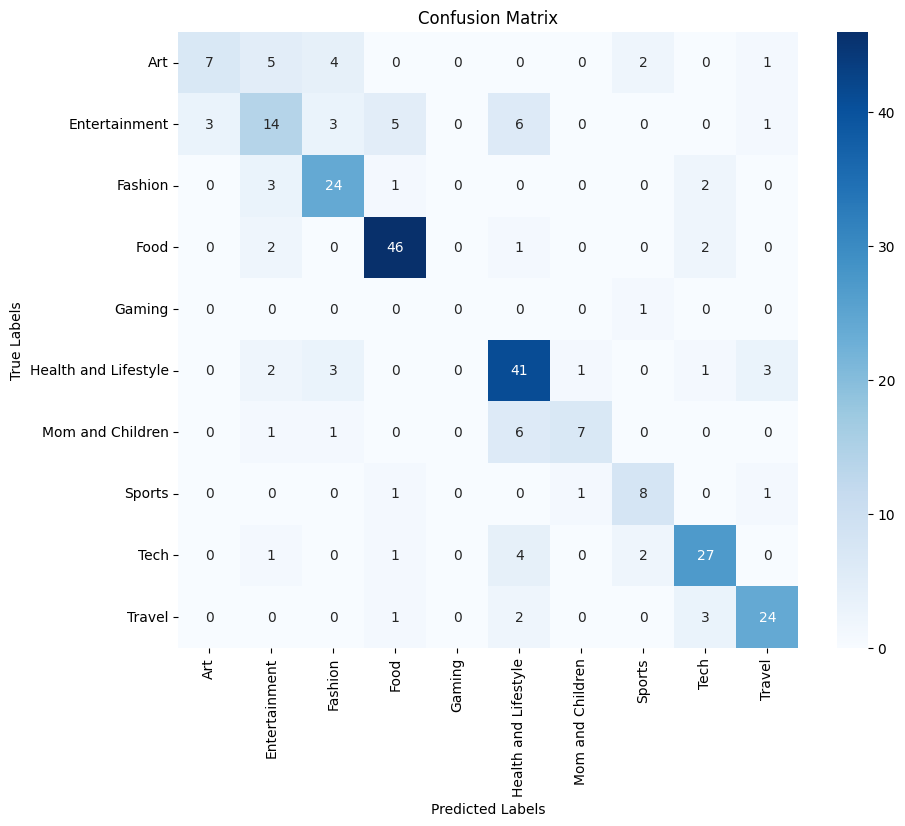

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Optionally normalize the confusion matrix
cm_normalized = confusion_matrix(y_val, y_val_pred, normalize='true')  # Normalize by row

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
final_predictions = {}

# Assign categories from annotated CSV
annotated_test_df = annotated_df[annotated_df['username'].isin(test_usernames)]
for _, row in annotated_test_df.iterrows():
    final_predictions[row['username']] = row['category']

# Assign predicted categories for unknown usernames
final_predictions.update(predicted_categories_dict)

# Save final predictions to a JSON file
output_filename = "prediction-classification-round1_testoutput.json"
with open(output_filename, "w") as json_file:
    json.dump(final_predictions, json_file, indent=4)

print(f"Final predictions saved to {output_filename}")

Final predictions saved to prediction-classification-round1_testoutput.json


In [21]:
#model.save_pretrained('berturk-instagram-classifier')
#tokenizer.save_pretrained('berturk-instagram-classifier')